In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- date: 날짜
- precipitation: 강수량(mm)
- temp_mean: 평균 기온(℃)
- temp_highest: 최고 기온(℃)
- temp_lowest: 최저 기온(℃)
- PM10: 미세먼지(㎍/㎥)
- PM2.5: 초미세먼지(㎍/㎥)
- humidity: 습도(%rh)
- sunshine_sum: 일조합
- sunshine_rate: 일조율
- wind_mean: 평균 풍속(m/s)
- wind_max: 최대 풍속(m/s)
- rentals : 따릉이 대여량

In [ ]:
import pandas as pd
import numpy as np 
import datetime as dt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from ngboost import NGBRegressor
#from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.utils import shuffle

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from sklearn.decomposition import PCA
from collections import Counter


In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 

import warnings 
warnings.filterwarnings(action = 'ignore')

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/데이콘/dacon_bike/train.csv")
test = pd.read_csv("/content/drive/MyDrive/데이콘/dacon_bike/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/데이콘/dacon_bike/sample_submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1095 non-null   object 
 1   precipitation  417 non-null    float64
 2   temp_mean      1095 non-null   float64
 3   temp_highest   1095 non-null   float64
 4   temp_lowest    1095 non-null   float64
 5   PM10           1028 non-null   float64
 6   PM2.5          1027 non-null   float64
 7   humidity       1095 non-null   float64
 8   sunshine_sum   1090 non-null   float64
 9   sunshine_rate  1095 non-null   float64
 10  wind_mean      1095 non-null   float64
 11  wind_max       1095 non-null   float64
 12  rental         1095 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 111.3+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           365 non-null    object 
 1   precipitation  160 non-null    float64
 2   temp_mean      365 non-null    float64
 3   temp_highest   365 non-null    float64
 4   temp_lowest    365 non-null    float64
 5   PM10           365 non-null    float64
 6   PM2.5          365 non-null    float64
 7   humidity       365 non-null    float64
 8   sunshine_sum   364 non-null    float64
 9   sunshine_rate  365 non-null    float64
 10  wind_mean      365 non-null    float64
 11  wind_max       365 non-null    float64
dtypes: float64(11), object(1)
memory usage: 34.3+ KB


In [ ]:
train['precipitation'] = train['precipitation'].fillna(0)
test['precipitation'] = test['precipitation'].fillna(0)

train = train.dropna(axis=0)

In [ ]:
test['sunshine_sum'] = test['sunshine_sum'].fillna(test['sunshine_sum'].mean())

In [ ]:
train['date']=pd.to_datetime(train['date'])
test['date']=pd.to_datetime(test['date'])

In [ ]:
train['date_month']=train['date'].dt.month
test['date_month']=test['date'].dt.month

In [ ]:
# 0 : 월요일 ~ 6 : 일요일
train['day_of_week']=train['date'].dt.dayofweek
test['day_of_week']=test['date'].dt.dayofweek

In [ ]:
train = train.drop('date', axis=1)
train.head()

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,date_month,day_of_week
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,1,0
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,1,1
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,1,2
3,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,1,3
4,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,1,4


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           365 non-null    object 
 1   precipitation  365 non-null    float64
 2   temp_mean      365 non-null    float64
 3   temp_highest   365 non-null    float64
 4   temp_lowest    365 non-null    float64
 5   PM10           365 non-null    float64
 6   PM2.5          365 non-null    float64
 7   humidity       365 non-null    float64
 8   sunshine_sum   365 non-null    float64
 9   sunshine_rate  365 non-null    float64
 10  wind_mean      365 non-null    float64
 11  wind_max       365 non-null    float64
 12  date_month     365 non-null    int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 37.2+ KB


In [ ]:
def detect_outliers(df,n,features):

    outlier_indices = []
    
   
    for col in features:
        # 제 1사분위수
        Q1 = np.percentile(df[col], 25)
        # 제 3 사분위수
        Q3 = np.percentile(df[col],75)
        # IQR
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        # 제 1 사분위수 - outlier_step 보다 작은 수,
        # 제 3사분위수 + outlier_step 보다 큰 수를 이상치로 지정
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # 각 outlier_list_col를 extend 함수를 통해 합친다.
        outlier_indices.extend(outlier_list_col)
        
    # outlier_indices의 각 인덱스별 개수
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# 2개 이상의 이상치가 있는 Age, SibSp, Parch, Fare에서 이상치 검출
Outliers_to_drop = detect_outliers(train,2,['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest',
       'PM10', 'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate',
       'wind_mean', 'wind_max'])

In [ ]:
train.loc[Outliers_to_drop]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,date_month,day_of_week
53,3.7,4.2,8.6,-0.3,79.0,55.0,81.1,4.8,43.2,1.9,5.0,6408,2,4
443,16.5,10.3,14.6,7.1,87.0,63.0,79.0,0.0,0.0,1.4,3.9,16204,3,2
707,1.7,8.1,10.8,6.0,97.0,80.0,82.3,2.0,20.6,1.2,3.5,33275,12,1
780,4.2,6.7,10.9,2.1,79.0,62.0,66.3,1.1,10.0,2.2,5.3,29779,2,4
910,64.7,20.1,23.1,18.4,9.0,5.0,83.0,0.0,0.0,4.0,7.6,38086,6,1
933,103.1,21.1,22.6,18.5,20.0,12.0,95.5,0.0,0.0,3.6,8.3,10739,7,3
934,2.9,22.5,26.8,18.7,6.0,3.0,74.3,1.0,7.0,4.6,8.7,76995,7,4
975,29.8,22.7,25.6,20.0,15.0,6.0,82.0,2.8,21.7,4.8,9.8,71524,9,3
979,61.0,19.2,20.6,17.5,8.0,4.0,93.5,0.0,0.0,4.2,7.9,3144,9,0


In [ ]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
train.shape

(1012, 14)

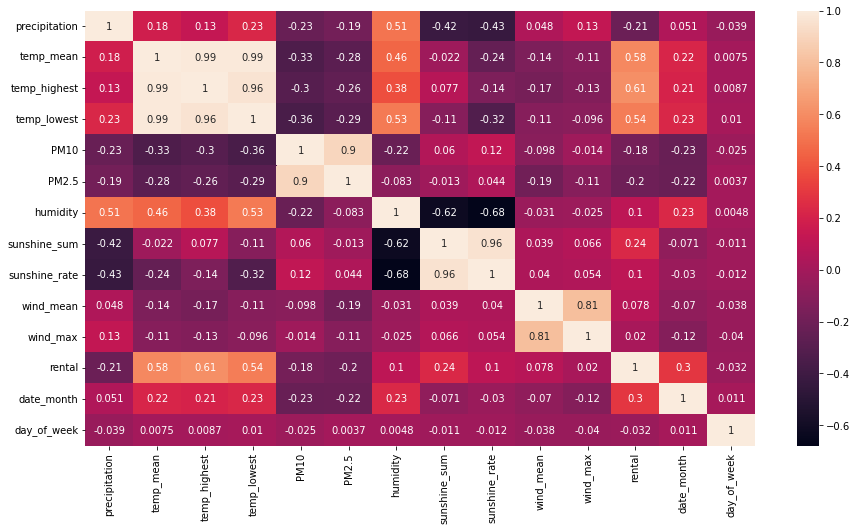

In [ ]:
data_corr = train.corr()
sns.heatmap(data_corr,annot=True)
plt.gcf().set_size_inches(15, 8)

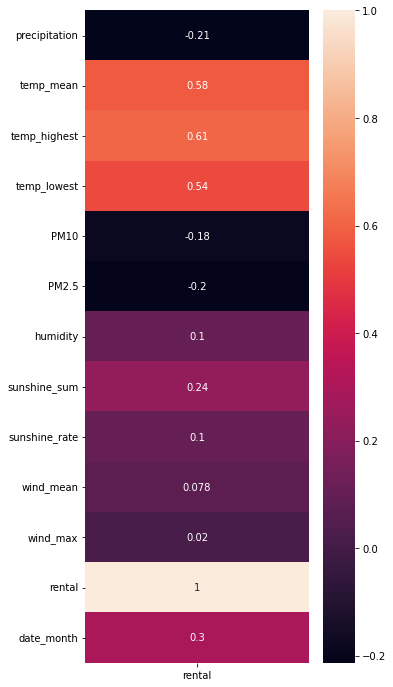

In [ ]:
plt.figure(figsize=(5, 12))
sns.heatmap(train.corr()[['rental']], annot=True)

In [ ]:
# 0 : 월, 1 : 화, 2 : 수, 3 : 목, 4 : 금, 5 : 토, 6 : 일,
pd.DataFrame(train.groupby(['day_of_week'])['rental'].mean()).sort_values(by='rental',ascending=False)

,rental
day_of_week,
4,52555.937063
1,51873.635135
3,50906.734266
5,49684.232394
2,49210.270833
0,48971.286667
6,44761.232394


In [ ]:
pd.DataFrame(train.groupby(['date_month'])['precipitation'].sum()).sort_values(by='precipitation',ascending=False)

,precipitation
date_month,
8,1060.2
7,518.3
5,345.7
9,296.2
11,278.0
6,234.9
10,176.0
4,155.7
2,95.5


In [ ]:
pd.DataFrame(train.groupby(['date_month'])['rental'].sum()).sort_values(by='rental',ascending=False)

,rental
date_month,
10,6748640
9,6217482
7,5601976
5,5339369
6,5279210
8,4737467
11,4462407
4,4143964
12,2545934


In [ ]:
train['month_rank'] = train.date_month.map({2 : 1, 1 : 2, 3 : 3, 12 : 4, 4 : 5,
                                      11 : 6, 8 : 7, 6 : 8, 5 : 9, 7 : 10, 9 : 11, 10 : 12})
test['month_rank'] = test.date_month.map({2 : 1, 1 : 2, 3 : 3, 12 : 4, 4 : 5,
                                      11 : 6, 8 : 7, 6 : 8, 5 : 9, 7 : 10, 9 : 11, 10 : 12})

In [ ]:
train.tail()

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,date_month,month_rank
1007,2020-12-27,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103,12,4
1008,2020-12-28,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912,12,4
1009,2020-12-29,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747,12,4
1010,2020-12-30,0.0,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488,12,4
1011,2020-12-31,0.0,-8.9,-5.0,-12.9,28.0,12.0,53.9,6.0,62.5,2.4,4.2,24535,12,4


In [ ]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [ ]:
X = train.drop(["date","rental","date_month","month_rank"],axis=1)
y = train["rental"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_test = test.drop(["date","date_month", "month_rank"], axis=1)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

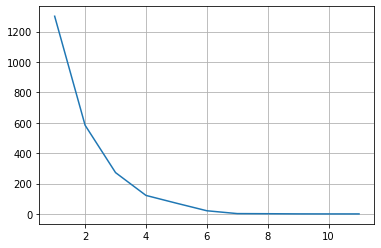

In [ ]:
pca = PCA()
pca.fit(X)
plt.plot(range(1, len(pca.explained_variance_) + 1 ), pca.explained_variance_)
plt.grid()

In [ ]:
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [ ]:
print(pca.n_components_)
print(np.sum(pca.explained_variance_ratio_))

6
0.9719995265651316


In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
params = {'n_estimators' : range(5, 60, 5), 'max_depth': range(1,15), 'max_features' : range(1,8)}

grid_search = GridSearchCV(rf, params, cv=5)
grid_search.fit(X_train, y_train)
grid_search.score(X_val, y_val)


0.6761682932312243

In [ ]:
print(grid_search.best_params_)

{'max_depth': 13, 'max_features': 5, 'n_estimators': 55}


In [ ]:
rf = RandomForestRegressor(max_depth = 10, max_features = 5, n_estimators = 55,random_state=42)
xgb = XGBRegressor(random_state=0)
lgbm = LGBMRegressor(random_state=0, learning_rate=0.1, max_depth=3, min_child_samples=1, min_child_weight=1)
model = rf.fit(X_train,y_train) 
pred = model.predict(X_val)

print(NMAE(y_val, pred))

0.41522883164313096


In [ ]:
rf.fit(X_train,y_train)
pred = rf.predict(X_test)

In [ ]:
submission["rental"] = np.round(pred,0)
submission["rental"] = submission["rental"].astype(int)
submission.to_csv('baseline_rf.csv', index=False)

In [ ]:
submission.head()

,date,rental
0,2021-01-01,20184
1,2021-01-02,15746
2,2021-01-03,12148
3,2021-01-04,12574
4,2021-01-05,9198
